# Demo JulES as a single watercourse model

### Import packages

In [1]:
# using Pkg; Pkg.status()
# Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables") # package not in JulES environment (you might have to Pkg.build(PlotlyJS))
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"JulES")); Pkg.status() # go to development version
# Pkg.add(url="https://github.com/NVE/TuLiPa.git"); Pkg.status() # alternative go back to latest version

In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, CSV, Plots, PrettyTables, Revise
# plotlyjs(); #uncomment for interactive plots

In [ ]:
# config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_fravansimtap_weeklydaily.yml")) # config with NVE datasets
config = YAML.load_file(joinpath("data", "config_jules_vassdrag.yml"))
weatheryear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1]

### Prepare parallell processing - import code on all cores

In [ ]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(dirname(pwd()))),"jgrc/TuLiPa/src/TuLiPa.jl"));

In [ ]:
@everywhere using JulES
# @everywhere include(joinpath(dirname(pwd()),"src/JulES.jl"));

### Read dataset

In [ ]:
function getdataset(config, scenarioyear)
    method = config["main"]["function"]
	if method == "nve_vassdrag"
        # Read watercourse, elspot area and price series
        watercourse = config["data"]["watercourse"]
        elspotnames = config["data"]["elspotnames"] # some watercourses are in several elspot areas
        priceseriesname = config["data"]["priceseriesname"] 

        # Read hydropower dataelements from json-files
        sti_dynmodelldata = joinpath(config["main"]["inputpath"], "dataset_vassdrag")
        tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata,"tidsserier_detd.json"))
        detdseries = getelements(tidsserie, sti_dynmodelldata);
        dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_" * watercourse * ".json"))
        detdstructure = getelements(dst);
        elements = vcat(detdseries,detdstructure)

        # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
        for elspotname in elspotnames
            addexogenbalance!(elements, "PowerBalance_" * elspotname, "Power", "AreaPrice")
        end

        # Add dataelements for price in exogen area
        price_path = joinpath(config["main"]["inputpath"], config["data"]["price"])
        df = CSV.read(price_path, DataFrame; header=3, decimal=',', types=Float64)
        df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
        df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
        df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
        push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
                Dict("Vector" => df.datetime)))
        push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
                Dict("Vector" => df[:,priceseriesname])))
        push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
                (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
        addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")

        return Dict("elements" => elements, "detailedrescopl" => Dict())
    elseif method == "nve_fravansimtap"
        # Read hydropower dataelements from json-files
        inputpath = config["main"]["inputpath"]
        inflowpath = config["data"]["tilsigsserier"]
        tidsserie = JulES.JSON.parsefile(joinpath(inflowpath,"tidsserier_detd.json"))
        detdseries = JulES.TuLiPa.getelements(tidsserie, inflowpath);
        dst = JulES.JSON.parsefile(joinpath(inputpath, "dataset_detd.json"))
        detdstructure = JulES.TuLiPa.getelements(dst);
        elements = vcat(detdseries,detdstructure)

        dataset = Dict("elements" => elements, "detailedrescopl" => Dict())

        # --- inflow model (ifm) ----
        iprogtype = get(config["data"], "iprogtype", "none")
        useifm = !(iprogtype in ["none"])
        if useifm
            ifm_names = String[]
            phaseindays = config["data"]["ifm_phaseindays"]
            preddays = config["data"]["ifm_preddays"]

            ifm_rhsterm_to_station = Dict{String, String}()
            ifm_empscode_to_stationid = JulES.JSON.parsefile(joinpath(inflowpath, "ifm_empscode_to_station.json"), dicttype=Dict{String, String})
            for i in eachindex(detdstructure)
                e = detdstructure[i]
                if startswith(e.instancename, "InflowSeriesParam")
                    empscode = join(split(e.value["Profile"], "_")[2:end], "_")
                    if haskey(ifm_empscode_to_stationid, empscode)
                        stationid = ifm_empscode_to_stationid[empscode]
                        e.value["ifm_station_id"] = stationid
                        e.value["phaseindays"] = phaseindays
                        e.value["preddays"] = preddays
                        push!(ifm_names, stationid)

                        rhstermname = replace(deepcopy(e.instancename), "SeriesParam" => "")
                        ifm_rhsterm_to_station[rhstermname] = stationid
                    end
                end
            end

            dataset["iprogtype"] = iprogtype
            dataset["ifm_names"] = ifm_names
            dataset["ifm_weights"] = Dict{String, Dict{String, Float64}}()
            dataset["ifm_normfactors"] = JulES.JSON.parsefile(joinpath(inflowpath, "ifm_normfactors.json"), dicttype=Dict{String, Float64})
            dataset["ifm_elements"] = JulES.TuLiPa.getelements(JulES.JSON.parsefile(joinpath(inflowpath, "ifm_elements.json")), inflowpath)
            dataset["ifm_rhsterm_to_station"] = ifm_rhsterm_to_station
        end

        return dataset
    end 
end

### Run JulES and keep the results

In [31]:
dataset = getdataset(config, weatheryear)
input = JulES.DefaultJulESInput(config, dataset, datayear, weatheryear)
JulES.cleanup_jules(input)
data = JulES.run_serial(input)

Time parameters
  0.000077 seconds (61 allocations: 2.500 KiB)
Handle elements
  0.000014 seconds (14 allocations: 1.219 KiB)
Add local dbs
  0.480056 seconds (621 allocations: 35.852 KiB)
Add local cores
  0.040235 seconds (518 allocations: 25.375 KiB)
Add local input
  1.816473 seconds (867.51 k allocations: 57.502 MiB, 27.22% compilation time)
Add local dummyobjects
  2.227849 seconds (17.85 k allocations: 1.510 MiB, 2.09% compilation time)
Add local subsystems
  0.234125 seconds (267.86 k allocations: 17.411 MiB, 52.79% compilation time)
Add local scenmod
  0.498960 seconds (518 allocations: 27.312 KiB)
Add local problem distribution
Tuple{String, Int64}[]
[(1, 1)]
[(1, 1, 1), (2, 1, 2), (3, 1, 3), (4, 1, 4), (5, 1, 5), (6, 1, 6), (7, 1, 7)]
1
  0.268877 seconds (182.56 k allocations: 12.158 MiB, 17.11% gc time, 51.04% compilation time)
Add local horizons
  0.429219 seconds (542 allocations: 27.562 KiB)
Add local problems
  6.593038 seconds (434.21 k allocations: 27.550 MiB, 5.54% 

Row,core,tot,evp_tot,mp_tot,sp_tot,evp_u,evp_s,evp_o,mp_u,mp_s,mp_fin,mp_o,sp_u,sp_s,sp_o
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.0299611,0.0,0.0194787,0.0104824,0.0,0.0,0.0,0.00329471,0.00408263,0.00139231,0.010709,0.00584588,0.00396907,0.000667466
2,3.0,0.0147561,0.0,0.0,0.0147561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00713565,0.00517121,0.00244923
3,5.0,0.0142004,0.0,0.0,0.0142004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00692977,0.00485534,0.0024153
4,7.0,0.0139202,0.0,0.0,0.0139202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00689284,0.00458573,0.00244161
5,6.0,0.0138489,0.0,0.0,0.0138489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0069788,0.00445372,0.00241636
6,2.0,0.0136852,0.0,0.0,0.0136852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00685686,0.0042445,0.00258385
7,4.0,0.0132163,0.0,0.0,0.0132163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00664071,0.00436423,0.00221132


Row,subix,tot,evp_tot,mp_tot,sp_tot,evp_u,evp_s,evp_o,bend_it,mp_u,mp_s,mp_fin,mp_o,sp_u,sp_s,sp_o
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.113588,0.0,0.0194787,0.0941094,0.0,0.0,0.0,5.36264,0.00329471,0.00408263,0.00139231,0.010709,0.0472805,0.0316438,0.0151851


Dict{Any, Any} with 27 entries:
  "demandbalancenames" => SubString{String}[]
  "skipfactor"         => 1.0
  "resindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "areanames"          => ["NO4"]
  "priceindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "batmatrix"          => Matrix{Float64}(undef, 364, 0)
  "stateindex"         => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "statematrix"        => [8.0 9.0 … 8.0 3506.0; 8.0 9.0 … 8.0 3506.0; … ; 5.95…
  "statenames"         => ["Reservoir_67301", "Reservoir_67306_max", "Reservoir…
  "resnames"           => ["Reservoir_67301", "Reservoir_67302", "Reservoir_673…
  "shorts"             => Bool[1, 1, 1]
  "demandvalues"       => Matrix{Float64}(undef, 364, 0)
  "batindex"           => [DateTime("1980-12-29T00:00:00"), DateTime("1980-12-3…
  "scenarionames"      => ["1 min", "1 max", "2 min", "2 max", "3 min", "3 max"…
  "storagenames"       => ["Reservoir_67301", "Reservoir

### Show some of the results

In [ ]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

scenweights_sim = data["scenweights_sim"]
scenweights_stoch = data["scenweights_stoch"]

storagevalues = data["storagevalues"]
storagenames = data["storagenames"]
scenarionames = data["scenarionames"]
shorts = data["shorts"]
skipfactor = data["skipfactor"];

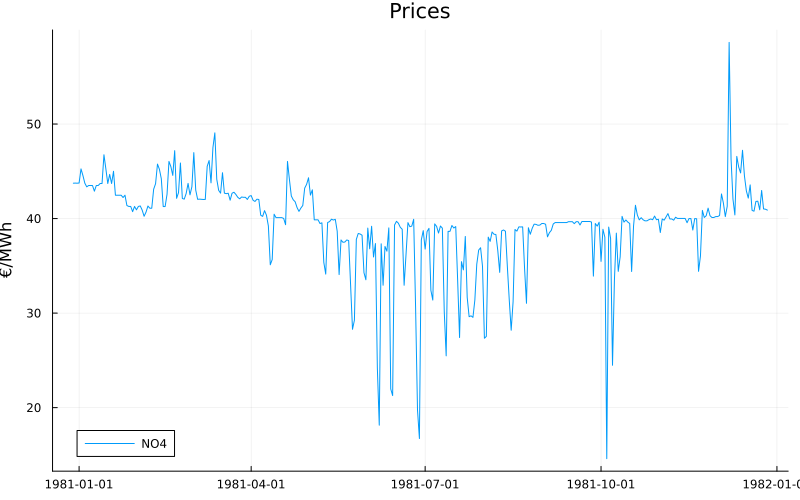

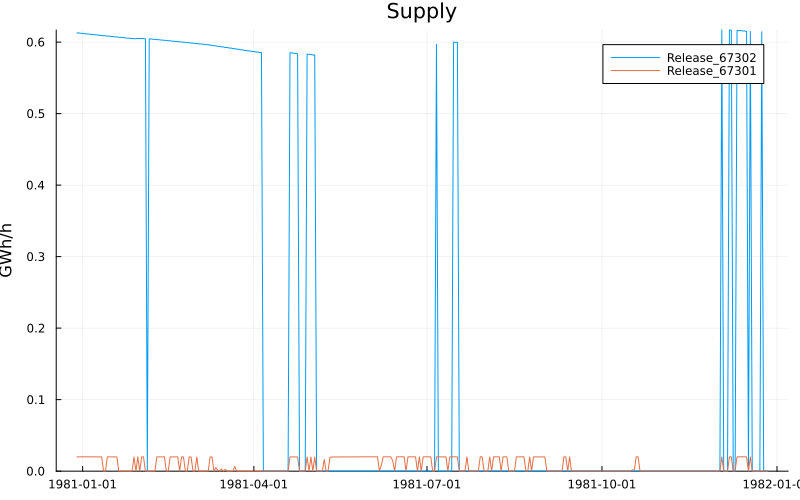

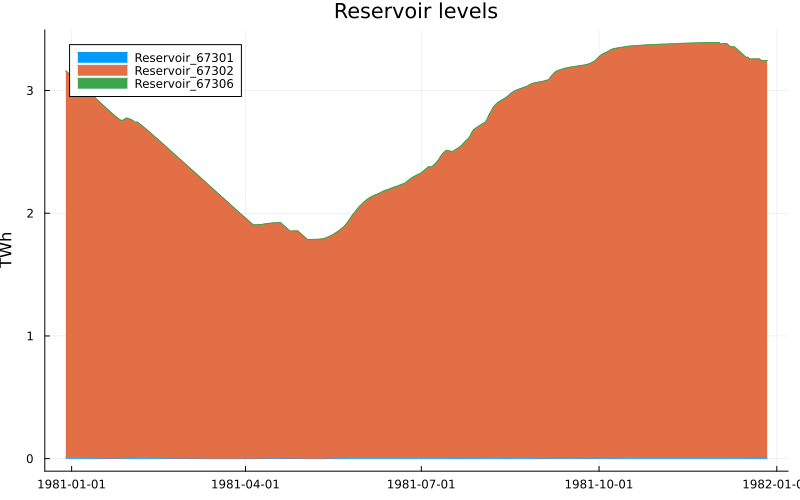

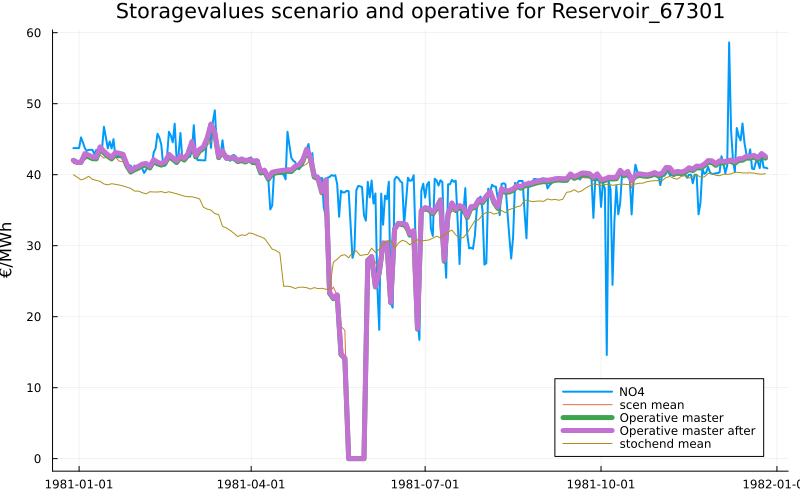

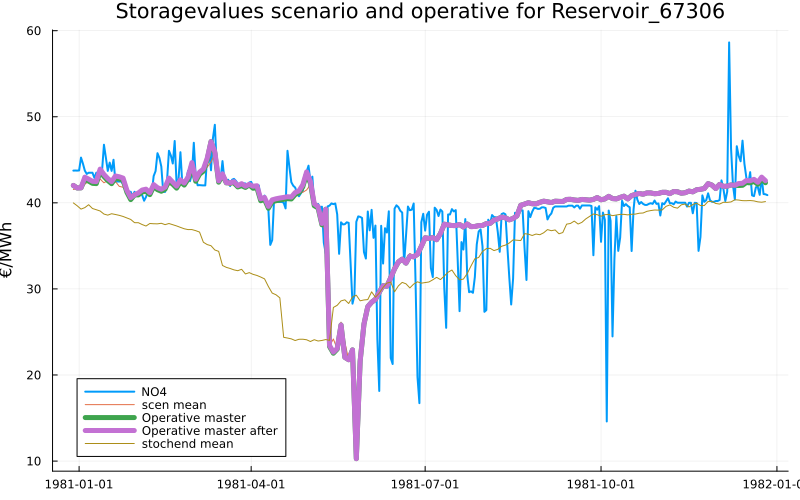

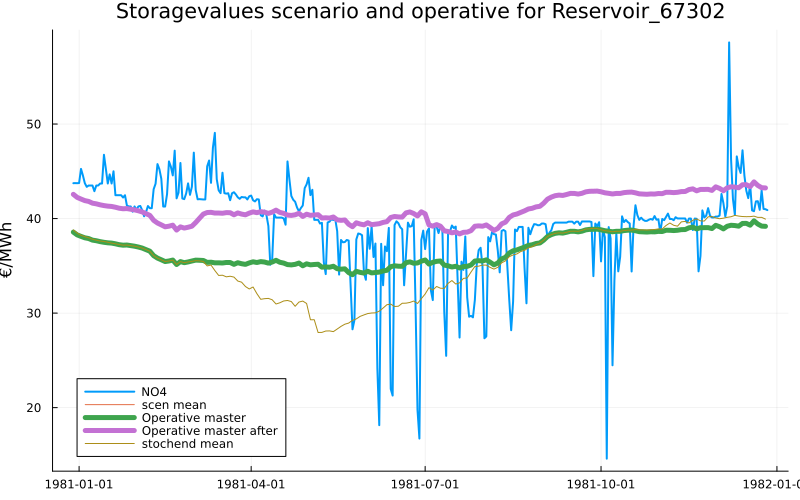

┌───────────────┬───────────────────┬────────────┬───────────────────┐
│    Supplyname │ Yearly_supply_TWh │ Demandname │ Yearly_demand_TWh │
│       String? │          Float64? │    String? │          Float64? │
├───────────────┼───────────────────┼────────────┼───────────────────┤
│ Release_67302 │           1.76294 │    missing │           missing │
│ Release_67301 │         0.0715835 │    missing │           missing │
└───────────────┴───────────────────┴────────────┴───────────────────┘
┌───────────────────────────────────┬───────────────────────────────────┐
│ Yearly_supply_TWh_sum_skipmissing │ Yearly_demand_TWh_sum_skipmissing │
│                           Float64 │                           Float64 │
├───────────────────────────────────┼───────────────────────────────────┤
│                           1.83453 │                               0.0 │
└───────────────────────────────────┴───────────────────────────────────┘


In [ ]:
# Plot prices
display(plot(x1, prices, labels=reshape(powerbalancenames,1,length(powerbalancenames)), size=(800,500), title="Prices", ylabel="€/MWh"))

# Plot supplies and demands
maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
display(plot(supplychart,size=(800,500)))
# sumsupplyvalues = sum(supplyvalues,dims=2)
# sumdemandvalues = sum(demandvalues,dims=2)
# maxdemsup = isempty(sumsupplyvalues) ? maximum(sumdemandvalues) : (isempty(sumdemandvalues) ? maximum(sumsupplyvalues) : max(maximum(sumdemandvalues), maximum(sumsupplyvalues)))
# supplychart = areaplot(x1,sumsupplyvalues,title="Supply", ylabel = "GWh/h")
# demandchart = areaplot(x1,sumdemandvalues,title="Demand", ylabel = "GWh/h")
# display(plot([supplychart,demandchart]...,layout=(1,2),size=(800,500)))

# Plot storages
display(areaplot(x2, hydrolevels,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
# display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total",size=(800,500),title="Reservoir levels", ylabel = "TWh")) #

# # Plot single storage
# for (i, statename) in enumerate(statenames)
#     if startswith(statename, "Reservoir_6_258")
#         display(plot(x3, statematrix[:, i], title="Filling for " * statename))
#     end
# end

# Plot list of yearly mean production and demand for each supply/demand TODO: split demand/supply and transmission
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader = true)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader = true)

# # Plot list of yearly income and cost for each supply/demand (only works if exogenprices are collected)
# supplyrev = copy(supplyvalues)
# for (i,supplybalancename) in enumerate(supplybalancenames)
#     idx = findfirst(isequal(supplybalancename), powerbalancenames)
#     supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
# end
# demandrev = copy(demandvalues)
# for (i,demandbalancename) in enumerate(demandbalancenames)
#     idx = findfirst(isequal(demandbalancename), powerbalancenames)
#     demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
# end
# meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
# meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
# supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
# demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
# supplyrevdf[!,:ID] = collect(1:length(supplynames))
# demandrevdf[!,:ID] = collect(1:length(demandnames))
# joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
# # pretty_table(joinedrevdf, show_subheader = true)

# # # Sum revenues and cost
# # pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader = true)

# Plot storagevalues for each reservoir and scenarios
maxlongtermstorages = 60
maxshorttermstorages = 30
shortindex = x3
medindex = x3[1:Int(skipfactor):end]
numstoch = length(findall(sn -> occursin("min", sn), scenarionames))*2
numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
numop_acc = numstoch + numop
numstochend = length(findall(sn -> occursin("stochend", sn), scenarionames))
numstochend_acc = numop_acc + numstochend
numevpend = length(findall(sn -> occursin("evpend", sn), scenarionames))
numevpend_acc = numstochend_acc + numevpend
j = 0
k = 0
for (i, storagename) in enumerate(storagenames)
    if shorts[i]
        j += 1
        j > maxshorttermstorages && continue
        storagevalues_ = storagevalues[:,:,:]
        scenweights_stoch_ = scenweights_stoch[:,:]
        index = shortindex
    else
        k += 1
        k > maxlongtermstorages && continue
        storagevalues_ = storagevalues[1:Int(skipfactor):end,:,:]
        scenweights_stoch_ = scenweights_stoch[1:Int(skipfactor):end,:]
        index = medindex
    end
    # p = plot(index, storagevalues_[:,1:numstoch,i] * -1, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numstoch], 1, numstoch), ylabel="€/MWh")
    # plot!(p, index, storagevalues_[:,numstoch+1:numop_acc,i] * -1, labels=reshape(scenarionames[numstoch+1:numop_acc], 1, numop), linewidth=5)
    # plot!(p, index, storagevalues_[:,numop_acc+1:numstochend_acc,i] * -1, labels=reshape(scenarionames[numop_acc+1:numstochend_acc], 1, numstochend))
    # if numevpend > 0
    #     plot!(p, index, storagevalues_[:,numstochend_acc+1:numevpend_acc,i] * -1, labels=reshape(scenarionames[numstochend_acc+1:numevpend_acc], 1, numevpend))
    # end
    stochvalues = (dropdims(sum(storagevalues_[:,1:2:numstoch,i] .* scenweights_stoch_,dims=2),dims=2) .+ dropdims(sum(storagevalues_[:,2:2:numstoch,i] .* scenweights_stoch_,dims=2),dims=2)) * -1 / 2
    p = plot(x1, prices[:, 1], labels=powerbalancenames[1], linewidth=2)
    plot!(p, index, stochvalues, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels="scen mean", ylabel="€/MWh")
    plot!(p, index, storagevalues_[:,numstoch+1:numop_acc,i] * -1, labels=reshape(scenarionames[numstoch+1:numop_acc], 1, numop), linewidth=5)
    plot!(p, index, dropdims(sum(storagevalues_[:,numop_acc+1:numstochend_acc,i] .* scenweights_stoch_,dims=2),dims=2) * -1, labels="stochend mean")
    if numevpend > 0
        plot!(p, index, dropdims(sum(storagevalues_[:,numstochend_acc+1:numevpend_acc,i] .* scenweights_stoch_,dims=2),dims=2) * -, labels="evpend mean")
    end
    display(p)
end

In [ ]:
# allsteamflow = data["ifm_allsteamflow"]
# actualsteamflow = data["actualsteamflow"]
# ifm_names = data["ifm_names"]

# num_stations = size(allsteamflow, 1)
# num_steps = size(allsteamflow, 2)
# num_predictions = size(allsteamflow, 3)

# steplength_days = Int((x3[2]-x3[1])/Day(1))
# colors = cgrad([:blue, :red], num_steps)

# for station in 1:num_stations
#     mean_actual = round(mean(actualsteamflow[station, :]), digits=1)
#     mean_pred =  round(mean(allsteamflow[station, :, :]), digits=1)
#     plt = plot(title="$(ifm_names[station]) (meanQ: $(mean_actual)) (meanpred: $mean_pred)", xlabel="Day", ylabel="Q", legend=false)

#     for step in 1:num_steps
#         days = [(step-1)*steplength_days + prediction_day for prediction_day in 1:num_predictions]
#         plot!(plt, days, allsteamflow[station, step, :], color=colors[step], alpha=0.25)
#     end

#     plot!(plt, actualsteamflow[station, :], color=:black)
    
#     display(plt)
# end